<a href="https://colab.research.google.com/github/PianoPlayer09/ConvLSTM/blob/main/CONVLSTM_%2B_PHYS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DANG! A lot of preprocessing


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 122.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import numpy as np
import rasterio
from skimage.transform import resize

# --------------------------------------------
# 1️⃣ Paths & regex
# --------------------------------------------
DATA_DIR = '/content/drive/MyDrive/Lake_Patches_All'
pattern = re.compile(r"lake_(\d+)_(\d{4})_(\d{1,2})\.tif")

# { lake_id: {(year, month): np.array} }
lakes = {}

# -------------------------------------------------------
# 2️⃣ Load & group by lake_id
# -------------------------------------------------------
for file in sorted(os.listdir(DATA_DIR)):
    if not file.endswith('.tif'): continue
    match = pattern.match(file)
    if not match: continue
    lake_id, year, month = map(int, match.groups())
    path = os.path.join(DATA_DIR, file)
    with rasterio.open(path) as src:
        arr = src.read().astype(np.float32)  # (bands, H, W)
        arr = np.transpose(arr, (1, 2, 0))   # → (H, W, bands)
    lakes.setdefault(lake_id, {})[(year, month)] = arr

print(f"✅ Loaded {len(lakes)} lakes")

# -------------------------------------------------------
# 3️⃣ Sort by time & stack into time series
# -------------------------------------------------------
lake_arrays = {}
for lake_id, time_dict in lakes.items():
    sorted_keys = sorted(time_dict.keys())
    stack = np.stack([time_dict[k] for k in sorted_keys], axis=0)  # (T, H, W, C)
    lake_arrays[lake_id] = stack
    print(f"Lake {lake_id}: {stack.shape}")

# -------------------------------------------------------
# 4️⃣ Compute largest patch size
# -------------------------------------------------------
max_h = max(arr.shape[1] for arr in lake_arrays.values())
max_w = max(arr.shape[2] for arr in lake_arrays.values())
print(f"📏 Largest patch = {max_h} * {max_w}")

# -------------------------------------------------------
# 5️⃣ Pad smaller patches to match largest
# -------------------------------------------------------
padded_lakes = {}
for lake_id, arr in lake_arrays.items():
    T, H, W, C = arr.shape
    pad_h = (max_h - H) // 2
    pad_w = (max_w - W) // 2
    padded = np.pad(
        arr,
        ((0,0), (pad_h, max_h-H-pad_h), (pad_w, max_w-W-pad_w), (0,0)),
        mode='constant', constant_values=0
    )
    padded_lakes[lake_id] = padded
    print(f"Lake {lake_id} padded: {H}*{W} → {max_h}*{max_w}")
# -------------------------------------------------------
# 6️⃣ Global min–max normalization (static vs dynamic)
# -------------------------------------------------------

# Compute global mins/maxs for static terrain bands (DEM, slope, aspect)
mins_list, maxs_list = [], []
for arr in padded_lakes.values():
    mins_list.append(arr.min(axis=(0,1,2)))
    maxs_list.append(arr.max(axis=(0,1,2)))

mins = np.min(np.stack(mins_list), axis=0)
maxs = np.max(np.stack(maxs_list), axis=0)

# Split bands: first 3 are static (DEM, slope, aspect), last 2 are dynamic (AWEI, melt)
mins_static = mins[:3]
maxs_static = maxs[:3]

# Apply normalization
for lake_id, arr in padded_lakes.items():
    arr_norm = arr.copy()

    # --- Static terrain (normalize globally, same for all timesteps)
    arr_norm[:, :, :, :3] = (arr[:, :, :, :3] - mins_static) / (maxs_static - mins_static + 1e-8)

    # --- Dynamic variables (normalize per lake time series)
    dyn = arr[:, :, :, 3:]                       # shape (T, H, W, 2)
    dyn_min = dyn.min()                          # per-lake min
    dyn_max = dyn.max()
    arr_norm[:, :, :, 3:] = (dyn - dyn_min) / (dyn_max - dyn_min + 1e-8)

    padded_lakes[lake_id] = arr_norm

print("✅ Normalized static bands globally and dynamic bands per lake time series.")

# -------------------------------------------------------
# 7️⃣ Verify
# -------------------------------------------------------
lake_id = list(padded_lakes.keys())[0]
example = padded_lakes[lake_id]
print(f"Example lake {lake_id} shape: {example.shape}, range: {example.min():.2f}-{example.max():.2f}")

✅ Loaded 20 lakes
Lake 1186: (25, 147, 146, 5)
Lake 1350: (24, 159, 158, 5)
Lake 1362: (24, 148, 147, 5)
Lake 1403: (24, 156, 156, 5)
Lake 2568: (24, 164, 163, 5)
Lake 2684: (24, 166, 165, 5)
Lake 2727: (24, 164, 164, 5)
Lake 2825: (24, 150, 149, 5)
Lake 2889: (27, 147, 146, 5)
Lake 2902: (23, 159, 159, 5)
Lake 3087: (25, 163, 162, 5)
Lake 3436: (24, 143, 142, 5)
Lake 357: (22, 143, 142, 5)
Lake 376: (23, 143, 142, 5)
Lake 401: (23, 143, 143, 5)
Lake 4229: (24, 162, 161, 5)
Lake 433: (24, 144, 143, 5)
Lake 464: (24, 144, 144, 5)
Lake 495: (22, 144, 143, 5)
Lake 690: (24, 143, 143, 5)
📏 Largest patch = 166 * 165
Lake 1186 padded: 147*146 → 166*165
Lake 1350 padded: 159*158 → 166*165
Lake 1362 padded: 148*147 → 166*165
Lake 1403 padded: 156*156 → 166*165
Lake 2568 padded: 164*163 → 166*165
Lake 2684 padded: 166*165 → 166*165
Lake 2727 padded: 164*164 → 166*165
Lake 2825 padded: 150*149 → 166*165
Lake 2889 padded: 147*146 → 166*165
Lake 2902 padded: 159*159 → 166*165
Lake 3087 padded: 163

In [ ]:
import os, re, numpy as np, rasterio

DATA_DIR = '/content/drive/MyDrive/Lake_Patches_All'
OUT_DIR  = '/content/drive/MyDrive/Lake_Patches_FFFFinal'
os.makedirs(OUT_DIR, exist_ok=True)

pattern = re.compile(r"lake_(\d+)_(\d{4})_(\d{1,2})\.tif")
TARGET_H, TARGET_W = 166, 165   # <- from your dataset stats

def pad_tif(src_path, dst_path, target_h, target_w):
    with rasterio.open(src_path) as src:
        arr = src.read().astype(np.float32)   # (bands, H, W)
        bands, h, w = arr.shape

        pad_h = (target_h - h) // 2
        pad_w = (target_w - w) // 2
        arr_padded = np.pad(
            arr,
            ((0, 0),
             (pad_h, target_h - h - pad_h),
             (pad_w, target_w - w - pad_w)),
            mode='constant',
            constant_values=0
        )

        meta = src.meta.copy()
        meta.update(height=target_h, width=target_w)
        with rasterio.open(dst_path, 'w', **meta) as dst:
            dst.write(arr_padded)

for file in os.listdir(DATA_DIR):
    if file.endswith('.tif') and pattern.match(file):
        src_path = os.path.join(DATA_DIR, file)
        dst_path = os.path.join(OUT_DIR, file)
        pad_tif(src_path, dst_path, TARGET_H, TARGET_W)

print("✅ All rasters padded to uniform size!")


✅ All rasters padded to uniform size!


Bands: 5
Shape: (5, 166, 165)
Band 1: NaNs=9,190, min=0.000, max=982.752, mean=607.972
Band 2: NaNs=9,190, min=0.000, max=55.000, mean=12.950
Band 3: NaNs=9,190, min=0.000, max=359.000, mean=129.872
Band 4: NaNs=9,190, min=0.000, max=5.037, mean=1.468
Band 5: NaNs=9,190, min=0.000, max=4.289, mean=3.519


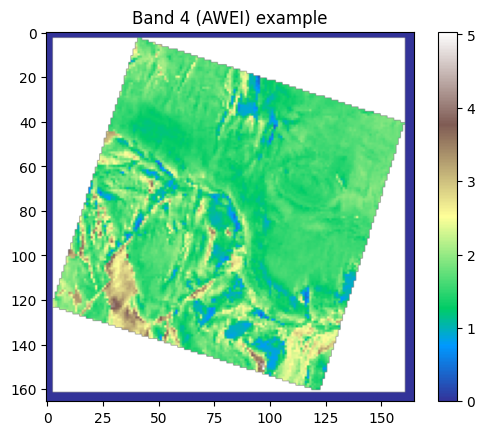

In [ ]:
import rasterio, numpy as np, matplotlib.pyplot as plt

SAVE_DIR = '/content/drive/MyDrive/Lake_Patches_FFFFinal/lake_1350_2022_7.tif'

with rasterio.open(SAVE_DIR) as src:
    arr = src.read().astype(float)    # (bands, H, W)
    print("Bands:", src.count)
    print("Shape:", arr.shape)

    for i in range(src.count):
        band = arr[i]
        print(
            f"Band {i+1}: NaNs={np.isnan(band).sum():,}, "
            f"min={np.nanmin(band):.3f}, max={np.nanmax(band):.3f}, "
            f"mean={np.nanmean(band):.3f}"
        )

plt.imshow(arr[3], cmap='terrain')
plt.title('Band 4 (AWEI) example')
plt.colorbar()
plt.show()


In [ ]:
import os, glob
import numpy as np
import rasterio

# --------------------------------------------
# 1️⃣ Locate all TIFFs
# --------------------------------------------
files = sorted(glob.glob('/content/drive/MyDrive/Lake_Patches_FFFFinal/*.tif'))
print(f"Found {len(files)} .tif files")

# --------------------------------------------
# 2️⃣ Convert each .tif → .npy (replace NaNs with 0)
# --------------------------------------------
for f in files:
    with rasterio.open(f) as src:
        arr = src.read().astype(np.float32)   # (bands, H, W)
        arr = np.nan_to_num(arr, nan=0.0)     # replace NaNs with 0

    npy_path = f.replace('.tif', '.npy')
    np.save(npy_path, arr)
    print(f"✅ Saved: {os.path.basename(npy_path)}  shape={arr.shape}, min={arr.min():.2f}, max={arr.max():.2f}")

print("\n🎉 All files converted to .npy and NaNs replaced with 0.0")


Found 478 .tif files
✅ Saved: lake_1186_2017_7.npy  shape=(5, 166, 165), min=0.00, max=684.77
✅ Saved: lake_1186_2019_6.npy  shape=(5, 166, 165), min=0.00, max=684.77
✅ Saved: lake_1186_2019_7.npy  shape=(5, 166, 165), min=0.00, max=684.77
✅ Saved: lake_1186_2019_8.npy  shape=(5, 166, 165), min=0.00, max=684.77
✅ Saved: lake_1186_2019_9.npy  shape=(5, 166, 165), min=0.00, max=684.77
✅ Saved: lake_1186_2020_6.npy  shape=(5, 166, 165), min=0.00, max=684.77
✅ Saved: lake_1186_2020_7.npy  shape=(5, 166, 165), min=0.00, max=684.77
✅ Saved: lake_1186_2020_8.npy  shape=(5, 166, 165), min=0.00, max=684.77
✅ Saved: lake_1186_2020_9.npy  shape=(5, 166, 165), min=0.00, max=684.77
✅ Saved: lake_1186_2021_6.npy  shape=(5, 166, 165), min=0.00, max=684.77
✅ Saved: lake_1186_2021_7.npy  shape=(5, 166, 165), min=0.00, max=684.77
✅ Saved: lake_1186_2021_8.npy  shape=(5, 166, 165), min=0.00, max=684.77
✅ Saved: lake_1186_2021_9.npy  shape=(5, 166, 165), min=0.00, max=684.77
✅ Saved: lake_1186_2022_6.npy 

In [ ]:
# Check ranges
for lake_id, arr in list(padded_lakes.items())[:3]:
    print(f"Lake {lake_id} | static range: {arr[:,:,:,0:3].min():.2f}-{arr[:,:,:,0:3].max():.2f}, "
          f"dynamic range: {arr[:,:,:,3:].min():.2f}-{arr[:,:,:,3:].max():.2f}")


Lake 1186 | static range: nan-nan, dynamic range: nan-nan
Lake 1350 | static range: nan-nan, dynamic range: nan-nan
Lake 1362 | static range: nan-nan, dynamic range: nan-nan


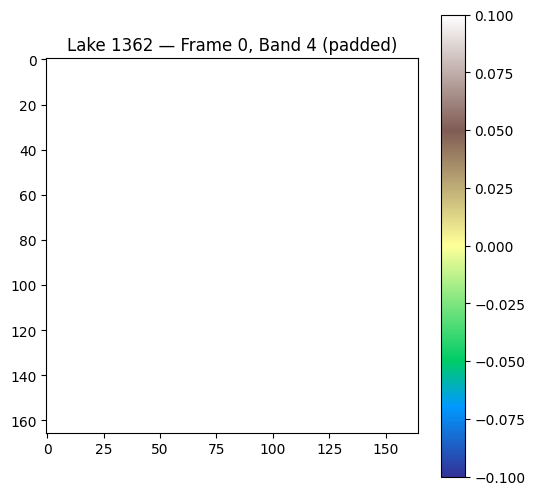

In [ ]:
import matplotlib.pyplot as plt

lake_id = list(padded_lakes.keys())[2]
arr = padded_lakes[lake_id]

# pick one month (frame) and one band (e.g., DEM)
t = 0
band = 4

plt.figure(figsize=(6,6))
plt.imshow(arr[t, :, :, band], cmap='terrain')
plt.title(f"Lake {lake_id} — Frame {t}, Band {band} (padded)")
plt.colorbar()
plt.show()


In [ ]:
import os
import re
import numpy as np

# --------------------------------------------
# 1️⃣ Define the path to your saved data
# --------------------------------------------
# This must be the *exact* same directory you saved the files to.
SAVE_DIR = '/content/drive/MyDrive/Lake_Patches_FFFFinal/'


# --------------------------------------------
# 2️⃣ Reload the lakes into a dictionary
# --------------------------------------------
padded_lakes = {}
pattern = re.compile(r"lake_(\d+)_\d+_\d+\.npy$")


print(f"🔎 Scanning for .npy files in {SAVE_DIR}...")

# Loop through all files in the directory
for file in sorted(os.listdir(SAVE_DIR)):
    # Check if the file matches our pattern
    match = pattern.match(file)
    if match:
        # Extract the lake_id (the digits) from the filename
        lake_id = int(match.group(1))

        # Construct the full path to the file
        path = os.path.join(SAVE_DIR, file)

        # Load the numpy array
        arr = np.load(path)

        # Add it to our dictionary
        padded_lakes[lake_id] = arr
        # print(f"  -> Loaded lake {lake_id}, shape={arr.shape}") # Optional: uncomment for verbose output

print(f"\n✅ Successfully reloaded {len(padded_lakes)} lakes into the 'padded_lakes' dictionary.")

# --------------------------------------------
# 3️⃣ Verify the data is loaded correctly
# --------------------------------------------
if padded_lakes:
    # Get the ID of the first lake in the dictionary
    example_id = list(padded_lakes.keys())[0]
    example_arr = padded_lakes[example_id]
    print(f"🔍 Verification successful for lake {example_id}:")
    print(f"   Shape: {example_arr.shape}")
    print(f"   Data type: {example_arr.dtype}")
    print(f"   Value range: {(example_arr)} to {example_arr.max():.2f}")
else:
    print("⚠️ Warning: No lakes were loaded. Check if the SAVE_DIR is correct and contains .npy files.")

🔎 Scanning for .npy files in /content/drive/MyDrive/Lake_Patches_FFFFinal/...

✅ Successfully reloaded 20 lakes into the 'padded_lakes' dictionary.
🔍 Verification successful for lake 1186:
   Shape: (5, 166, 165)
   Data type: float32
   Value range: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 

In [ ]:
#Checking for validation

In [ ]:
import numpy as np

arr = np.load("/content/drive/MyDrive/Lake_Patches_FFFFinal/lake_1403_2024_9.npy")

# Assuming array shape is (time, height, width, bands)
print("Shape:", arr.shape)

# Melt is band 5 (1-indexed), so index 4 (0-indexed)
melt = arr[..., 4].astype(float)

print("NaNs:", np.isnan(melt).sum())
print("Min:", np.nanmin(melt), "Max:", np.nanmax(melt))
print("Mean:", np.nanmean(melt))


Shape: (5, 166, 165)
NaNs: 0
Min: 0.0 Max: 870.2869873046875
Mean: 2.6454589102641646


##Now for actual Testing

In [ ]:
## DOING THIS AGAIN IDK WHY
import os, re, numpy as np, glob

# --------------------------------------------
# 1️⃣ Load all .npy files and group by lake
# --------------------------------------------
DATA_DIR = '/content/drive/MyDrive/Lake_Patches_FFinal/'
pattern = re.compile(r"lake_(\d+)_(\d{4})_(\d{1,2})\.npy")

lakes = {}

files = sorted(glob.glob(os.path.join(DATA_DIR, "*.npy")))
for f in files:
    match = pattern.search(f)
    if not match:
        continue
    lake_id, year, month = map(int, match.groups())
    arr = np.load(f)                     # (5, H, W)
    arr = np.transpose(arr, (1, 2, 0))   # → (H, W, 5)
    lakes.setdefault(lake_id, {})[(year, month)] = arr

print(f"✅ Loaded {len(lakes)} lakes")

# --------------------------------------------
# 2️⃣ Stack time series per lake
# --------------------------------------------
lake_arrays = {}
for lake_id, months in lakes.items():
    sorted_keys = sorted(months.keys())           # (year, month)
    stack = np.stack([months[k] for k in sorted_keys], axis=0)  # (T, H, W, 5)
    lake_arrays[lake_id] = stack
    print(f"Lake {lake_id}: {stack.shape}")

# --------------------------------------------
# 3️⃣ Compute global normalization factors
# --------------------------------------------
mins_list, maxs_list = [], []
for arr in lake_arrays.values():
    mins_list.append(arr.min(axis=(0,1,2)))
    maxs_list.append(arr.max(axis=(0,1,2)))

mins = np.min(np.stack(mins_list), axis=0)
maxs = np.max(np.stack(maxs_list), axis=0)
print("Global band min:", mins)
print("Global band max:", maxs)

# --------------------------------------------
# 4️⃣ Apply correct normalization
# --------------------------------------------
# Bands: [0]=DEM, [1]=slope, [2]=aspect → static
#        [3]=AWEI, [4]=melt → dynamic
mins_static = mins[:3]
maxs_static = maxs[:3]

for lake_id, arr in lake_arrays.items():
    arr_norm = arr.copy()

    # --- Static bands normalized globally (same across all time steps)
    arr_norm[:, :, :, :3] = (arr[:, :, :, :3] - mins_static) / (maxs_static - mins_static + 1e-8)

    # --- Dynamic bands normalized per-lake (preserve local seasonality)
    for b in range(3, 5):
        band = arr[:, :, :, b]
        b_min = band.min()
        b_max = band.max()
        arr_norm[:, :, :, b] = (band - b_min) / (b_max - b_min + 1e-8)

    lake_arrays[lake_id] = arr_norm

print("✅ Normalized static bands globally and dynamic bands per-lake.")

# --------------------------------------------
# 5️⃣ Build ConvLSTM sequences
# --------------------------------------------
def build_sequences(lake_dict, lookback=8, target_band=3):
    X, y = [], []
    for arr in lake_dict.values():
        T, H, W, C = arr.shape
        for t in range(T - lookback):
            X.append(arr[t:t+lookback])                   # (lookback, H, W, 5)
            y.append(arr[t+lookback, :, :, target_band])  # (H, W)
    return np.array(X), np.array(y)

X, y = build_sequences(lake_arrays, lookback=8, target_band=3)
print(f"\n✅ Final dataset ready!")
print(f"X: {X.shape}   y: {y.shape}")


✅ Loaded 20 lakes
Lake 1186: (25, 166, 165, 5)
Lake 1350: (24, 166, 165, 5)
Lake 1362: (24, 166, 165, 5)
Lake 1403: (24, 166, 165, 5)
Lake 2568: (24, 166, 165, 5)
Lake 2684: (24, 166, 165, 5)
Lake 2727: (24, 166, 165, 5)
Lake 2825: (24, 166, 165, 5)
Lake 2889: (27, 166, 165, 5)
Lake 2902: (23, 166, 165, 5)
Lake 3087: (25, 166, 165, 5)
Lake 3436: (24, 166, 165, 5)
Lake 357: (22, 166, 165, 5)
Lake 376: (23, 166, 165, 5)
Lake 401: (23, 166, 165, 5)
Lake 4229: (24, 166, 165, 5)
Lake 433: (24, 166, 165, 5)
Lake 464: (24, 166, 165, 5)
Lake 495: (22, 166, 165, 5)
Lake 690: (24, 166, 165, 5)
Global band min: [0. 0. 0. 0. 0.]
Global band max: [2081.864      78.        359.          8.306738   11.261972]
✅ Normalized static bands globally and dynamic bands per-lake.

✅ Final dataset ready!
X: (318, 8, 166, 165, 5)   y: (318, 166, 165)


In [ ]:
def build_sequences(lake_dict, lookback=8, target_band=3):
    X, y = [], []
    for arr in lake_dict.values():
        T, H, W, C = arr.shape
        for t in range(T - lookback):
            X.append(arr[t:t+lookback])         # (8, H, W, 5)
            y.append(arr[t+lookback, :, :, target_band])  # (H, W) - AWEI
    return np.array(X), np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: split into train+temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: split temp into validation and test (half-half of the 30%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (222, 8, 166, 165, 5), Val: (48, 8, 166, 165, 5), Test: (48, 8, 166, 165, 5)


In [ ]:
X, y = build_sequences(lake_arrays, lookback=8, target_band=3)
print(f"\n✅ Final dataset ready!")
print(f"X: {X.shape}   y: {y.shape}")


✅ Final dataset ready!
X: (318, 8, 166, 165, 5)   y: (318, 166, 165)


In [ ]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D

model = Sequential([
    ConvLSTM2D(
        filters=32, kernel_size=(3,3), padding='same',
        activation='relu', return_sequences=False,
        input_shape=(X.shape[1], X.shape[2], X.shape[3], X.shape[4])
    ),
    BatchNormalization(),
    Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 166, 165, 32)   │        42,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 166, 165, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 166, 165, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,169 (168.63 KB)

 Trainable params: 43,105 (168.38 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=25, batch_size=4)


Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.0074 - val_loss: 0.0055
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 0.0074 - val_loss: 0.0057
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.0060 - val_loss: 0.0063
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - loss: 0.0063 - val_loss: 0.0070
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - loss: 0.0062 - val_loss: 0.0049
Epoch 9/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 10/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 11/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 12/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step

In [ ]:
model.save("/content/drive/MyDrive/Greenland_ConvLSTM_NonPhys_Finetuned.keras")

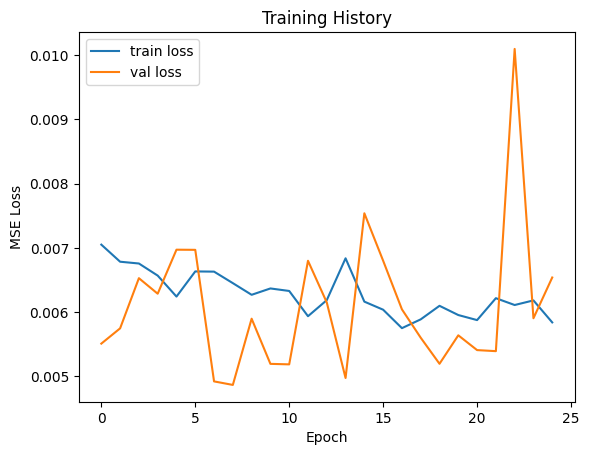

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training History')
plt.show()


In [ ]:
y_pred = model.predict(X_val)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


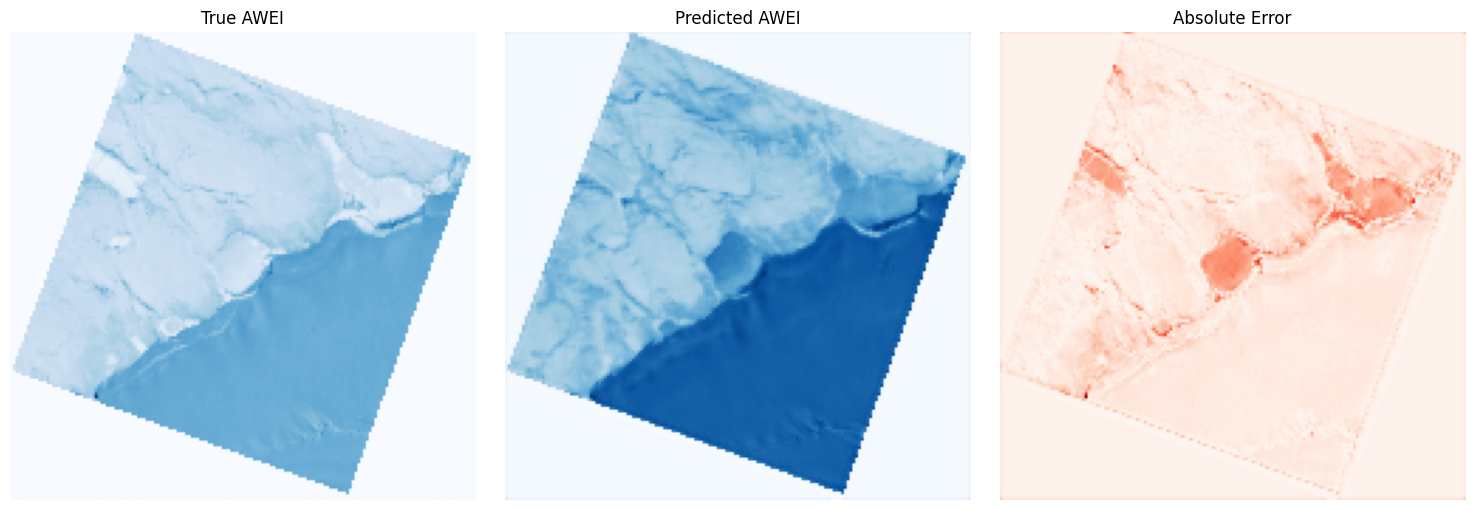

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# pick one test example
i = np.random.randint(0, len(y_val))
pred = y_pred[i, :, :, 0]  # (H, W)
true = y_val[i, :, :]      # (H, W)

fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].imshow(true, cmap='Blues')
axs[0].set_title('True AWEI')

axs[1].imshow(pred, cmap='Blues')
axs[1].set_title('Predicted AWEI')

axs[2].imshow(np.abs(pred - true), cmap='Reds')
axs[2].set_title('Absolute Error')

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_val.flatten(), y_pred.flatten())
r2 = r2_score(y_val.flatten(), y_pred.flatten())

print("MSE:", mse)
print("R² score:", r2)


MSE: 0.006539599504321814
R² score: 0.8142036199569702


In [ ]:
import numpy as np, tensorflow as tf

def r2(y, yhat):
    y = y.reshape(-1); yhat = yhat.reshape(-1)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-9
    return 1 - ss_res/ss_tot

def predict(model, X, batch_size=8):
    return model.predict(X, batch_size=batch_size, verbose=0)


In [ ]:
def channel_permutation_importance(model, X, y_true, channel_names):
    base_pred = predict(model, X)
    base_r2 = r2(y_true, base_pred)
    imps = []
    for c, name in enumerate(channel_names):
        X_perm = X.copy()
        # permute within batch for each (t,h,w)
        for t in range(X.shape[1]):
            for h in range(X.shape[2]):
                for w in range(X.shape[3]):
                    np.random.shuffle(X_perm[:, t, h, w, c])
        y_hat = predict(model, X_perm)
        imps.append({'channel': name, 'ΔR2': base_r2 - r2(y_true, y_hat)})
    return sorted(imps, key=lambda d: d['ΔR2'], reverse=True)


In [ ]:
def channel_ablation(model, X, y_true, channel_names, fill='mean'):
    base_pred = predict(model, X)
    base_r2 = r2(y_true, base_pred)
    imps = []
    ch_means = np.mean(X, axis=(0,1,2,3), keepdims=True)  # (1,1,1,1,C)
    for c, name in enumerate(channel_names):
        X_ab = X.copy()
        X_ab[..., c] = ch_means[..., c] if fill=='mean' else 0.0
        y_hat = predict(model, X_ab)
        imps.append({'channel': name, 'ΔR2': base_r2 - r2(y_true, y_hat)})
    return sorted(imps, key=lambda d: d['ΔR2'], reverse=True)


In [ ]:
@tf.function
def _interp_pred_and_grad(model, x0, x1, alphas):
    x0 = tf.cast(x0, tf.float32); x1 = tf.cast(x1, tf.float32)
    grads = []
    preds = []
    for a in alphas:
        x = x0 + a*(x1 - x0)
        with tf.GradientTape() as tape:
            tape.watch(x)
            y = model(x, training=False)
            # if sequence output, you can pick last step: y = y[:,-1]
            y_scalar = tf.reduce_mean(y)  # aggregate to scalar for IG
        g = tape.gradient(y_scalar, x)
        grads.append(g); preds.append(y)
    return tf.stack(grads), tf.stack(preds)

def integrated_gradients_channel_importance(model, X_batch, channel_names, m_steps=32):
    # Use a small random batch for speed
    x1 = tf.convert_to_tensor(X_batch[:8])
    x0 = tf.zeros_like(x1)  # baseline: all-zero (or mean tensor)
    alphas = tf.linspace(0.0, 1.0, m_steps)
    grads, _ = _interp_pred_and_grad(model, x0, x1, alphas)  # (m, B, T,H,W,C)
    avg_grads = tf.reduce_mean(grads, axis=0)  # average over alphas
    ig = (x1 - x0) * avg_grads  # (B,T,H,W,C)
    # Aggregate IG to per-channel scores
    ch_scores = tf.reduce_mean(tf.abs(ig), axis=(0,1,2,3)).numpy()  # (C,)
    return [{'channel': name, 'IG': float(ch_scores[i])} for i, name in enumerate(channel_names)]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam

class PhysicsLossLayer(layers.Layer):
    def __init__(
        self,
        lambda_mass=5e-2,
        lambda_topo=1e-2,
        mass_gain_per_melt=1e-1,
        melt_horizon=3,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.lambda_mass = lambda_mass
        self.lambda_topo = lambda_topo
        self.k = mass_gain_per_melt
        self.melt_horizon = melt_horizon

    def call(self, inputs, training=None):
        """
        inputs = [y_pred, seq]
        y_pred: (B,H,W,1)
        seq:    (B,T,H,W,C): 0=DEM,1=slope,2=aspect,3=AWEI,4=melt
        """
        y_pred, seq = inputs
        B = tf.shape(seq)[0]
        T = tf.shape(seq)[1]

        # ----- VALID MASK -----
        dem_seq = seq[..., 0]
        valid_mask = tf.cast(tf.reduce_mean(dem_seq, axis=1) > 0.0, tf.float32)
        valid_mask = valid_mask[..., None]
        valid_px = tf.reduce_sum(valid_mask, axis=[1,2,3]) + 1e-6

        # ----- PREVIOUS AWEI -----
        awei_prev = seq[:, -1, :, :, 3:4]

        # ----- MELT CONTEXT -----
        melt_seq = seq[..., 4]
        K = tf.minimum(self.melt_horizon, T)
        recent_melt = melt_seq[:, -K:, :, :]
        melt_mean = tf.reduce_mean(recent_melt, axis=[1,2,3])
        melt_mean = tf.clip_by_value(melt_mean, 0.0, 1.0)   # ensure in [0,1]

        # ----- MASS BALANCE -----
        area_pred = tf.reduce_sum(y_pred * valid_mask, axis=[1,2,3]) / valid_px
        area_prev = tf.reduce_sum(awei_prev * valid_mask, axis=[1,2,3]) / valid_px
        delta_area = tf.abs(area_pred - area_prev)
        allowance = self.k * melt_mean
        mass_violation = tf.nn.relu(delta_area - allowance)
        mass_loss = tf.reduce_mean(mass_violation)

        # ----- TOPOGRAPHIC PENALTY -----
        slope_seq = seq[..., 1]
        slope_map = tf.reduce_mean(slope_seq, axis=1)
        s_max = tf.reduce_max(slope_map)
        slope_norm = tf.where(s_max > 1.5, slope_map / 90.0, slope_map)
        slope_norm = tf.clip_by_value(slope_norm, 0.0, 1.0)[..., None]
        steepness = tf.nn.relu(slope_norm - 0.10)
        topo_loss = tf.reduce_mean(steepness * y_pred * valid_mask)

        # ----- ADD PHYSICS PENALTIES -----
        self.add_loss(self.lambda_mass * mass_loss)
        self.add_loss(self.lambda_topo * topo_loss)

        # Optional debug print
        if tf.executing_eagerly():
            tf.print(
                "[PhysicsLoss]",
                "mass_loss:", mass_loss,
                "topo_loss:", topo_loss,
                "Δarea(mean):", tf.reduce_mean(delta_area),
                "allow(mean):", tf.reduce_mean(allowance)
            )

        return y_pred


# ====== Build physics-informed model ======
from tensorflow.keras.models import load_model

baseline_path = '/content/drive/MyDrive/Greenland_ConvLSTM_Baseline.keras'
base_model = load_model(baseline_path, compile=False)
print("✅ Baseline model loaded:", baseline_path)

seq_in = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4]), name='seq_input')
y_pred = base_model(seq_in)

phys_out = PhysicsLossLayer(
    lambda_mass=5e-2,
    lambda_topo=1e-2,
    mass_gain_per_melt=1e-1,
    melt_horizon=3
)([y_pred, seq_in])

phys_model = Model(inputs=seq_in, outputs=phys_out, name='ConvLSTM_Physics')
phys_model.compile(optimizer=Adam(5e-5, clipnorm=1.0), loss='mse')
phys_model.summary()


✅ Baseline model loaded: /content/drive/MyDrive/Greenland_ConvLSTM_Baseline.keras


Model: "ConvLSTM_Physics"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 8, 166,    │          0 │ -                 │
│ (InputLayer)        │ 165, 5)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 166, 165,  │     43,169 │ seq_input[0][0]   │
│ (Sequential)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ physics_loss_layer… │ (None, 166, 165,  │          0 │ sequential[0][0], │
│ (PhysicsLossLayer)  │ 1)                │            │ seq_input[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,169 (168.63 KB)

 Trainable params: 43,105 (168.38 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
# =========================================================
# ⚙️  Imports
# =========================================================
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# =========================================================
# 🔬  Custom Physics Loss Layer
# =========================================================
class PhysicsLossLayer(layers.Layer):
    def __init__(
        self,
        lambda_mass=5e-2,
        lambda_topo=1e-2,
        mass_gain_per_melt=1e-1,
        melt_horizon=3,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.lambda_mass = lambda_mass
        self.lambda_topo = lambda_topo
        self.k = mass_gain_per_melt
        self.melt_horizon = melt_horizon

    def call(self, inputs, training=None):
        y_pred, seq = inputs   # y_pred:(B,H,W,1), seq:(B,T,H,W,C)
        B = tf.shape(seq)[0]
        T = tf.shape(seq)[1]

        # ----- VALID MASK -----
        dem_seq = seq[..., 0]
        valid_mask = tf.cast(tf.reduce_mean(dem_seq, axis=1) > 0.0, tf.float32)
        valid_mask = valid_mask[..., None]
        valid_px = tf.reduce_sum(valid_mask, axis=[1,2,3]) + 1e-6

        # ----- PREVIOUS AWEI -----
        awei_prev = seq[:, -1, :, :, 3:4]

        # ----- MELT CONTEXT -----
        melt_seq = seq[..., 4]
        K = tf.minimum(self.melt_horizon, T)
        recent_melt = melt_seq[:, -K:, :, :]
        melt_mean = tf.reduce_mean(recent_melt, axis=[1,2,3])
        melt_mean = tf.clip_by_value(melt_mean, 0.0, 1.0)

        # ----- MASS BALANCE -----
        area_pred = tf.reduce_sum(y_pred * valid_mask, axis=[1,2,3]) / valid_px
        area_prev = tf.reduce_sum(awei_prev * valid_mask, axis=[1,2,3]) / valid_px
        delta_area = tf.abs(area_pred - area_prev)
        allowance = self.k * melt_mean
        mass_violation = tf.nn.relu(delta_area - allowance)
        mass_loss = tf.reduce_mean(mass_violation)

        # ----- TOPOGRAPHIC PENALTY -----
        slope_seq = seq[..., 1]
        slope_map = tf.reduce_mean(slope_seq, axis=1)
        s_max = tf.reduce_max(slope_map)
        slope_norm = tf.where(s_max > 1.5, slope_map / 90.0, slope_map)
        slope_norm = tf.clip_by_value(slope_norm, 0.0, 1.0)[..., None]
        steepness = tf.nn.relu(slope_norm - 0.10)
        topo_loss = tf.reduce_mean(steepness * y_pred * valid_mask)

        # ----- ADD PHYSICS PENALTIES -----
        self.add_loss(self.lambda_mass * mass_loss)
        self.add_loss(self.lambda_topo * topo_loss)

        # Optional: debug print
        if tf.executing_eagerly():
            tf.print(
                "[PhysicsLoss]",
                "mass_loss:", mass_loss,
                "topo_loss:", topo_loss,
                "Δarea(mean):", tf.reduce_mean(delta_area),
                "allow(mean):", tf.reduce_mean(allowance)
            )

        return y_pred


# =========================================================
# 🧩  Load baseline ConvLSTM and wrap with physics layer
# =========================================================
baseline_path = '/content/drive/MyDrive/Greenland_ConvLSTM_Baseline.keras'
base_model = load_model(baseline_path, compile=False)
print("✅ Baseline model loaded:", baseline_path)

seq_in = Input(shape=(X_train.shape[1], X_train.shape[2],
                      X_train.shape[3], X_train.shape[4]), name='seq_input')

# baseline predicts next-month AWEI
y_pred = base_model(seq_in)

# physics wrapper
phys_out = PhysicsLossLayer(
    lambda_mass=5e-2,
    lambda_topo=1e-2,
    mass_gain_per_melt=1e-1,
    melt_horizon=3
)([y_pred, seq_in])

phys_model = Model(inputs=seq_in, outputs=phys_out, name='ConvLSTM_Physics')
phys_model.compile(optimizer=Adam(5e-5, clipnorm=1.0), loss='mse')
phys_model.summary()


# =========================================================
# 🏋️  Train / Fine-tune
# =========================================================
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=6, restore_best_weights=True)
]

history_phys = phys_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=4,
    callbacks=callbacks,
    verbose=1
)


# =========================================================
# 📊  Evaluate
# =========================================================
y_pred_test = phys_model.predict(X_test, verbose=0)
mse = mean_squared_error(y_test.flatten(), y_pred_test.flatten())
r2  = r2_score(y_test.flatten(), y_pred_test.flatten())

print("\nFinal Physics-Informed Test Results:")
print(f"MSE: {mse:.6f}")
print(f"R²:  {r2:.4f}")


# =========================================================
# 💾  Save
# =========================================================
save_path = '/content/drive/MyDrive/Greenland_ConvLSTM_Physics_Finetuned.keras'
phys_model.save(save_path)
print("💾 Saved physics-informed model to", save_path)


✅ Baseline model loaded: /content/drive/MyDrive/Greenland_ConvLSTM_Baseline.keras


Model: "ConvLSTM_Physics"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 8, 166,    │          0 │ -                 │
│ (InputLayer)        │ 165, 5)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 166, 165,  │     43,169 │ seq_input[0][0]   │
│ (Sequential)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ physics_loss_layer  │ (None, 166, 165,  │          0 │ sequential[0][0], │
│ (PhysicsLossLayer)  │ 1)                │            │ seq_input[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,169 (168.63 KB)

 Trainable params: 43,105 (168.38 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/30


KeyboardInterrupt: 

In [ ]:

import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Layer

# --- Define your custom PhysicsLossLayer exactly as used during training ---
@tf.keras.utils.register_keras_serializable()
class PhysicsLossLayer(Layer):
    def __init__(self, lambda_mass=0.05, lambda_topo=0.01, mass_gain_per_melt=0.1, melt_horizon=3, **kwargs):
        super().__init__(**kwargs)
        self.lambda_mass = lambda_mass
        self.lambda_topo = lambda_topo
        self.mass_gain_per_melt = mass_gain_per_melt
        self.melt_horizon = melt_horizon

    def call(self, inputs):
        y_pred, x_seq = inputs  # predicted map and input sequence
        # You can leave it empty if only needed for architecture loading
        return y_pred

# --- Now load the model, telling Keras how to interpret the layer ---
physics_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/Greenland_ConvLSTM_Physics_Finetuned.keras",
    compile=False,
    custom_objects={"PhysicsLossLayer": PhysicsLossLayer}
)

regular_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/Greenland_ConvLSTM_NonPhys_Finetuned.keras",
    compile=False
)
# --- Load your test data ---
# X_test: (N, 8, H, W, 5)  [last dim: DEM, slope, aspect, AWEI, melt]
# y_test: (N, H, W)        [true AWEI at t+1]

# --- Get predictions from both models ---
y_pred_regular = regular_model.predict(X_test)
y_pred_physics = physics_model.predict(X_test)

# Remove channel dimension if present
if y_pred_regular.ndim == 4:
    y_pred_regular = y_pred_regular[..., 0]
if y_pred_physics.ndim == 4:
    y_pred_physics = y_pred_physics[..., 0]

# --- Create valid mask (DEM > 0) ---
dem_seq = X_test[..., 0]  # (N, T, H, W)
valid_mask = (dem_seq.mean(axis=1) > 0)  # (N, H, W)

# --- Metric 1: Water on Steep Slopes ---
SLOPE_THRESH = 15.0/90.0  # degrees (water shouldn't be here)
WATER_THRESH = 0.3   # AWEI threshold for "water"

slope_seq = X_test[..., 1]  # (N, T, H, W)
slope_map = slope_seq.mean(axis=1)  # (N, H, W)
steep_mask = slope_map > SLOPE_THRESH

# Count violations
water_regular = y_pred_regular > WATER_THRESH
water_physics = y_pred_physics > WATER_THRESH

violations_regular = []
violations_physics = []

for i in range(len(y_test)):
    valid = valid_mask[i]
    total_valid_pixels = valid.sum()

    if total_valid_pixels == 0:
        continue

    # Regular model violations
    bad_pixels_reg = np.logical_and.reduce([valid, steep_mask[i], water_regular[i]])
    viol_reg = bad_pixels_reg.sum() / total_valid_pixels
    violations_regular.append(viol_reg)

    # Physics model violations
    bad_pixels_phys = np.logical_and.reduce([valid, steep_mask[i], water_physics[i]])
    viol_phys = bad_pixels_phys.sum() / total_valid_pixels
    violations_physics.append(viol_phys)

viol_reg_pct = 100 * np.mean(violations_regular)
viol_phys_pct = 100 * np.mean(violations_physics)

print(f"Water on steep slopes (>{SLOPE_THRESH}°):")
print(f"  Regular model:  {viol_reg_pct:.2f}%")
print(f"  Physics model:  {viol_phys_pct:.2f}%")
print(f"  Reduction:      {viol_reg_pct - viol_phys_pct:.2f}% (lower is better)")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 779ms/step
Water on steep slopes (>0.16666666666666666°):
  Regular model:  6.40%
  Physics model:  5.70%
  Reduction:      0.70% (lower is better)


In [ ]:
# --- Metric 2: Mass Balance Consistency ---
# Previous AWEI (last frame in input window)
awei_prev = X_test[:, -1, :, :, 3]  # (N, H, W)

# Melt forcing (normalized)
melt_seq = X_test[..., 4]  # (N, T, H, W)
melt_mean = melt_seq.mean(axis=(1,2,3))  # (N,)
melt_max = melt_mean.max()
melt_norm = melt_mean / (melt_max + 1e-6) if melt_max > 0 else melt_mean

# Mass balance check parameter (tune this based on your training)
K_MASS = 0.1  # or whatever you used in PhysicsLossLayer

mass_viols_regular = []
mass_viols_physics = []

for i in range(len(y_test)):
    valid = valid_mask[i]
    denom = valid.sum() + 1e-6

    # Normalized area (0-1 scale)
    area_prev = (awei_prev[i][valid] > WATER_THRESH).sum() / denom
    area_pred_reg = (y_pred_regular[i][valid] > WATER_THRESH).sum() / denom
    area_pred_phys = (y_pred_physics[i][valid] > WATER_THRESH).sum() / denom

    # Expected allowable change
    allowance = K_MASS * melt_norm[i]

    # Violations (change exceeds melt-justified allowance)
    delta_reg = abs(area_pred_reg - area_prev)
    delta_phys = abs(area_pred_phys - area_prev)

    mass_viols_regular.append(max(0, delta_reg - allowance))
    mass_viols_physics.append(max(0, delta_phys - allowance))

mass_viol_reg = np.mean(mass_viols_regular)
mass_viol_phys = np.mean(mass_viols_physics)

print(f"\nMass balance violations:")
print(f"  Regular model:  {mass_viol_reg:.4f}")
print(f"  Physics model:  {mass_viol_phys:.4f}")
print(f"  Reduction:      {100*(mass_viol_reg - mass_viol_phys)/mass_viol_reg:.1f}%")


Mass balance violations:
  Regular model:  0.1889
  Physics model:  0.1646
  Reduction:      12.9%
